In [4]:
import os
import glob
import datetime
import numpy as np
import soundfile as sf
from essentia.standard import *
import matplotlib.pyplot as plt

from tqdm import tqdm
from essentia.standard import *
from scipy.signal import butter, lfilter
from scipy.interpolate import make_interp_spline, BSpline

eps = np.finfo(np.float64).eps

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format = 'retina'

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [6]:
def normalized_mean_spectrum(audio_file, ratio_idxs, fs=16000, harmonic=False, f0="max"):
    
    # note: this function is still too slow, we need to optimize it more
    
    freq_data_mean_ln = np.zeros(shape=(len(ratio_idxs),))
    
    # we start by instantiating the audio loader
    try:
        loader = essentia.standard.MonoLoader(filename=audio_file, sampleRate=fs)
    except:
        return freq_data_mean_ln

    # and then we actually perform the loading
    audio = loader()
    
    # apply a lowpass filter to focus on speeech
    #lowpass = LowPass(cutoffFrequency=8000, sampleRate=fs)
    #audio = lowpass(audio)
    
    # Some configuration parameters
    N = 2048
    H = N//2
    fMax = 5000
    fMin = 50
    w = Windowing(type='blackmanharris92')
    ratio_density = len(ratio_idxs)
    
    spectrum = Spectrum()
    
    spectralPeaks = SpectralPeaks(magnitudeThreshold=-80,
                                  maxFrequency=fMax,
                                  maxPeaks=len(ratio_idxs),
                                  minFrequency=fMin,
                                  sampleRate=fs) 
    
    harmonicPeaks = HarmonicPeaks(maxHarmonics=20,
                                  tolerance=0.2)
    
    pitchYin = PitchYin(frameSize=N,
                        interpolate=True,
                        maxFrequency=fMax,
                        minFrequency=fMin,
                        sampleRate=fs,
                        tolerance=0.15)
       
    pool = essentia.Pool()

    for frame in FrameGenerator(audio, frameSize=N, hopSize=H, startFromZero=True):
            
        dBSpectrum = 20 * np.log10(spectrum(w(frame)) + eps)
        freqs, magsdB = spectralPeaks(dBSpectrum)
        
        if f0 == "yin":
            p, pConf = pitchYin(frame)
        else:
            if len(freqs) > 0:
                p = freqs[np.argmax(magsdB)]
                pConf = 1.0
            else:
                p = 0
                pConf = 0.0
        
        if harmonic:
            hFreqs, hMags = harmonicPeaks(freqs, magsdB, p)
            pool.add('hFreqs', hFreqs)
            pool.add('hMags',  hMags)

        pool.add('freqs',  freqs)
        pool.add('magsdB', magsdB)
        pool.add('magsLn', np.power(10, magsdB/20))
        pool.add('p',      p)
        pool.add('pConf',  pConf)
    
    if harmonic:
        vFreqs = pool['hFreqs']
        vMags  = pool['hMags']
    else:
        vFreqs = pool['freqs']
        vMags  = pool['magsLn']
    
    for freqs, mags, p, pConf in zip(vFreqs, vMags, pool['p'], pool['pConf']):
        # skip if no f0 found
        if pConf <= 0.0:
            continue
        
        # skip if no peaks are found
        if len(freqs) < 1 or len(mags) < 1:
            continue
        
        f0_freq = p
        
        for peak_freq, peak_mag in zip(freqs, mags):
            
            octave_freq = f0_freq
            current_ratio = peak_freq / octave_freq
            
            
            while current_ratio > 3.0:
                octave_freq *= 2
                current_ratio = peak_freq / octave_freq

            r1 = current_ratio
            
            if current_ratio > 2.0 and current_ratio < 2.2:
                ratio_idx = np.squeeze(np.argwhere(ratio_idxs == find_nearest(ratio_idxs, r1)))
                freq_data_mean_ln[ratio_idx] += peak_mag
                
            while current_ratio > 2.0:
                octave_freq *= 2
                current_ratio = peak_freq / octave_freq

            r2 = current_ratio
            
            ratio_idx = np.squeeze(np.argwhere(ratio_idxs == find_nearest(ratio_idxs, r2)))
            freq_data_mean_ln[ratio_idx] += peak_mag
    
                        
            while current_ratio > 1.0:
                octave_freq *= 2
                current_ratio = peak_freq / octave_freq

            r3 = current_ratio
            
            ratio_idx = np.squeeze(np.argwhere(ratio_idxs == find_nearest(ratio_idxs, r3)))
            freq_data_mean_ln[ratio_idx] += peak_mag
    
    # normalize
    freq_data_mean_ln /= freq_data_mean_ln.shape[0]
    
    return freq_data_mean_ln


In [7]:
def plot_mean_spectrum(ratio_idx, freq_data_mean_db, lang=None, nfiles=None, f0=None, output_dir=None):
    
    common = [6/5, 5/4, 4/3, 7/5, 3/2, 8/5, 5/3, 9/5, 2/1]
    names = ["m3", "M3", "P4", "tt", "P5", " m6", "M6", "m7", "P8"]
    
    filename = f"lang_{lang}_files_{nfiles}_f0_{f0}"
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ylim_min = -50
    ylim_max = 3
    ylim_range  = ylim_max - ylim_min
    
    plt.plot(ratio_idx, freq_data_mean_db, c='r', zorder=2)
    for ratio, name in zip(common, names):
        idx = np.argwhere(ratio_idx == find_nearest(ratio_idx, ratio))
        x_val = ratio_idx[idx]
        ymin = ((53 - np.abs(np.squeeze(freq_data_mean_db[idx]))) - 1) / ylim_range
        ymax = ymin + 0.08
        
        ymag = np.squeeze(freq_data_mean_db[idx])
        
        plt.axvline(x_val, ymin=ymin, ymax=ymax, c='k', zorder=2, linewidth=1.0)
        plt.text(x_val-0.01, ymag+7, name, weight='bold')
        
    plt.xticks(np.arange(0.9, 2.1, 0.1))
    plt.xlim([0.9, 2.1])
    plt.ylim([-50,3])
    plt.ylabel('Mean amplitude (dB)')
    plt.xlabel('f0 ratio')
    plt.title(f"{lang} {nfiles} ex. {f0} f0 est.")
    plt.grid(axis='y')
    
    if output_dir:
        # save out plot
        plot_path = os.path.join(output_dir, filename + ".pdf")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        
        # save out plot data
        data_path = os.path.join(output_dir, f"{filename}_freq_data_mean_db.txt")
        idxs_path = os.path.join(output_dir, f"{filename}_ratio_idx.txt")
        np.savetxt(data_path, freq_data_mean_db)
        np.savetxt(idxs_path, ratio_idx)
        
    plt.close(fig)

In [8]:
def analyze_dataset(audio_files, f0="max", lang=None, output_dir="./"):
    
    if len(audio_files) < 1:
        print("No audio files...")
        return
    
    ratio_density = 500
    ratio_start = 0.0
    ratio_stop  = 2.2
    ratio_idxs = np.linspace(ratio_start, ratio_stop, ratio_density)
    
    freq_data_mean_ln = np.zeros(ratio_density)
    
    for audio_file in audio_files:
        freq_data_mean_ln += normalized_mean_spectrum(audio_file, ratio_idxs, f0=f0)
        
    freq_data_mean_ln /= len(audio_files)
    freq_data_mean_db = 20 * np.log10((freq_data_mean_ln + eps)/np.max(freq_data_mean_ln + eps))
    
    plot_mean_spectrum(ratio_idxs, freq_data_mean_db, lang=lang, nfiles=len(audio_files), f0=f0, output_dir=output_dir)

In [9]:
def make_output_dir(root="./"):
    datecode = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    dir_path = os.path.join(root, datecode)
    
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    else:
        print(f"Directory {dir_path} already exisits.")
        
    return dir_path

In [10]:
langs = ["en", "de", "fr" ,"br" ,"cv", "cy", "tr", "tt", "ky", "ga-IE", "kab", "ca", "zh-TW", "sl", 
         "it", "nl", "cnh", "eo", "et", "fa" ,"eu" ,"es", "zh-CN", "mn", "sah", "dv", "rw", "sv-SE", "ru"]
N = 4000 # analyze N files from each language

In [11]:
output_dir = make_output_dir(root="logs/")
for lang in tqdm(langs):
    lang_dir = os.path.join(output_dir, lang)
    if not os.path.isdir(lang_dir):
        os.makedirs(lang_dir)
    voice_files = glob.glob(f"/Volumes/SteinmetzAlpha/Datasets/Speech/{lang}/clips/*.mp3")[:N]
    analyze_dataset(voice_files, f0="max", lang=lang, output_dir=lang_dir)

100%|██████████| 29/29 [8:43:40<00:00, 1083.47s/it]  


## Questions and improvements

- How should f0 estimation be handled (max vs yin vs ?)
- In what way should we fold higher harmonics into the range of 1.0 to 2.0?
- Should the range of ratios extend more (ex: 0.9 - 2.1)?
- How do we statistically compare two specta?

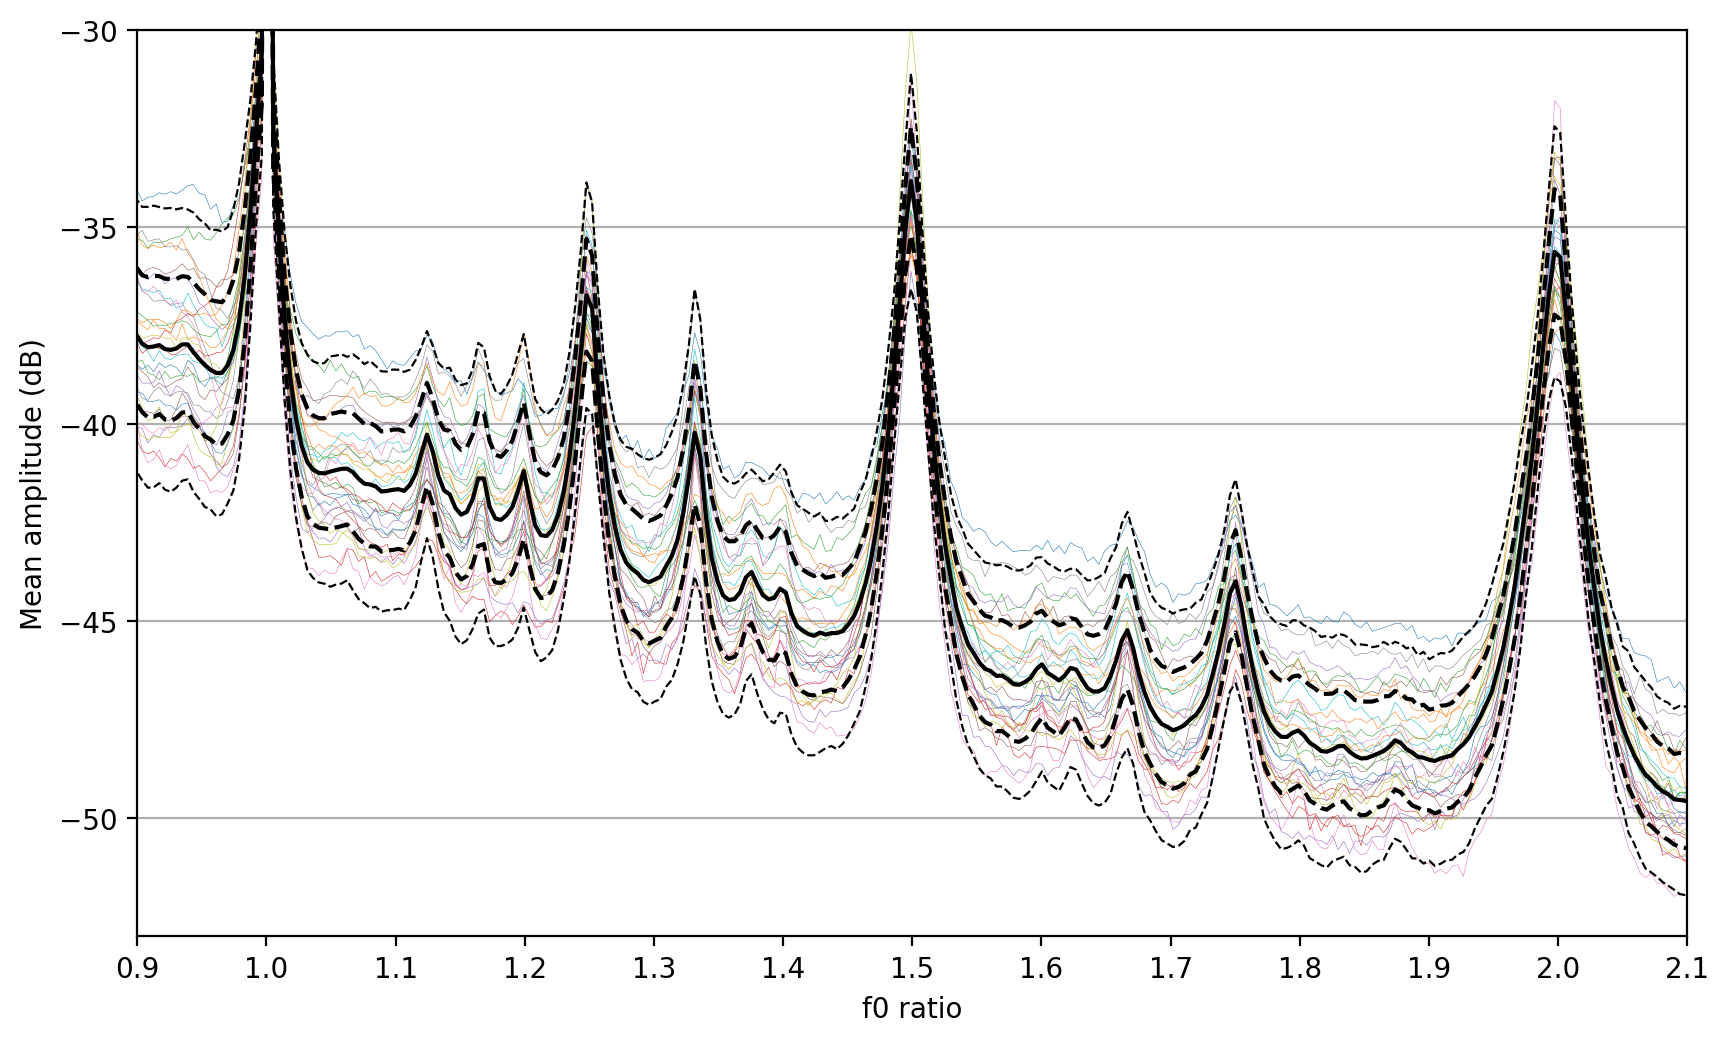

In [14]:
log_dir = "logs/20191115-010609"

ratio_density = 500
freq_data_mean_db = np.empty(shape=(ratio_density,len(langs)))

for idx, lang in enumerate(langs):
    freq_data_mean_db_file = glob.glob(os.path.join(log_dir, lang, "*freq_data_mean_db.txt"))[0]
    ratio_idx_file = glob.glob(os.path.join(log_dir, lang, "*ratio_idx.txt"))[0]   
    freq_data_mean_db[:,idx] = np.loadtxt(freq_data_mean_db_file)
    ratio_idx = np.loadtxt(ratio_idx_file)
    
spectrum_mean = np.mean(freq_data_mean_db, axis=1)
spectrum_std  = np.std(freq_data_mean_db, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

for idx, lang in enumerate(langs):
    plt.plot(ratio_idx, freq_data_mean_db[:,idx], linewidth=0.2)
    
plt.plot(ratio_idx, spectrum_mean, c="k", zorder=99)
plt.plot(ratio_idx, spectrum_mean + spectrum_std, linestyle="--", c='k', zorder=99)
plt.plot(ratio_idx, spectrum_mean - spectrum_std, linestyle="--", c='k', zorder=99)
plt.plot(ratio_idx, spectrum_mean + 2 * spectrum_std, linestyle="--", c='k', linewidth=0.8,  zorder=99)
plt.plot(ratio_idx, spectrum_mean - 2 * spectrum_std, linestyle="--", c='k', linewidth=0.8, zorder=99)
plt.xticks(np.arange(0.9, 2.1, 0.1))
plt.xlim([0.9, 2.1])
plt.ylim([-53,-30])
plt.ylabel('Mean amplitude (dB)')
plt.xlabel('f0 ratio')
plt.grid(axis='y')
plt.show()
plt.close(fig)

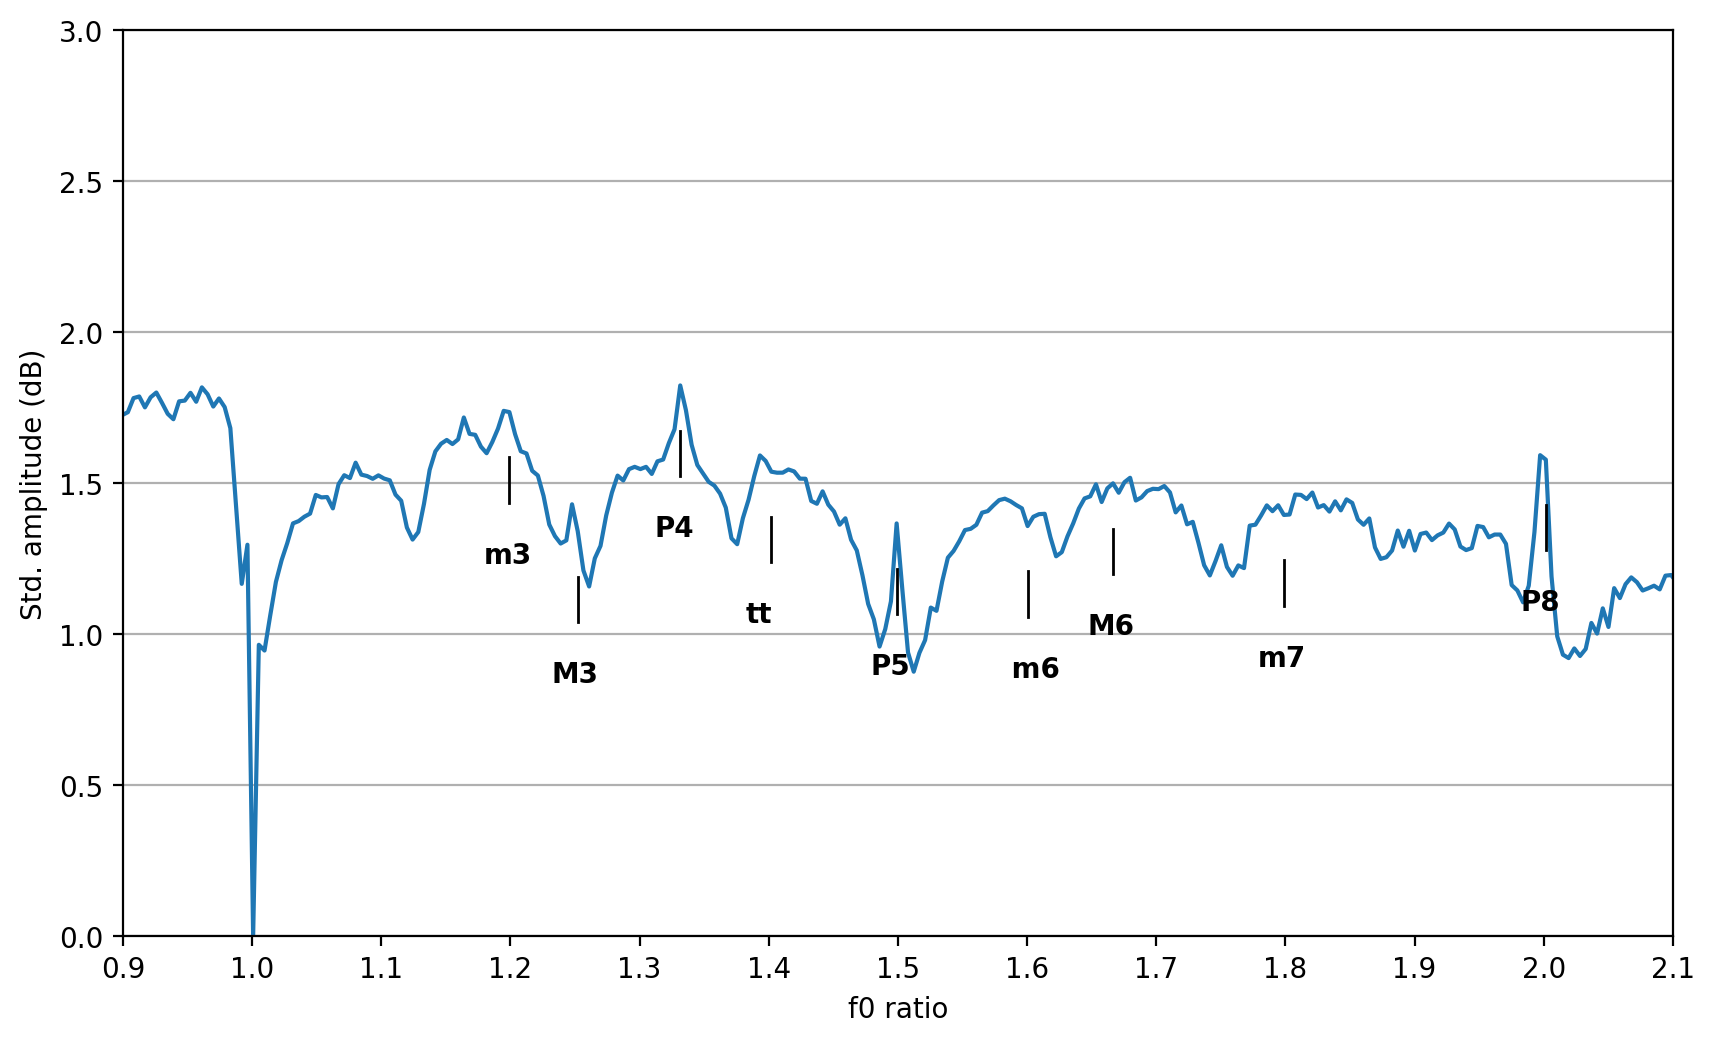

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(ratio_idx, spectrum_std)

common = [6/5, 5/4, 4/3, 7/5, 3/2, 8/5, 5/3, 9/5, 2/1]
names = ["m3", "M3", "P4", "tt", "P5", " m6", "M6", "m7", "P8"]
    
ylim_range = 3

for ratio, name in zip(common, names):
    idx = np.argwhere(ratio_idx == find_nearest(ratio_idx, ratio))
    x_val = ratio_idx[idx]
    ymin = np.abs(np.squeeze(spectrum_std[idx])) / ylim_range
    ymax = ymin + 0.08

    ymag = np.squeeze(spectrum_std[idx])

    plt.axvline(x_val, ymin=ymin-0.05, ymax=ymin-0.1, c='k', zorder=2, linewidth=1.0)
    plt.text(x_val-0.02, ymag-0.5, name, weight='bold')

plt.xticks(np.arange(0.9, 2.1, 0.1))
plt.xlim([0.9, 2.1])
plt.ylim([0,3])
plt.ylabel('Std. amplitude (dB)')
plt.xlabel('f0 ratio')
plt.grid(axis='y')
plt.show()



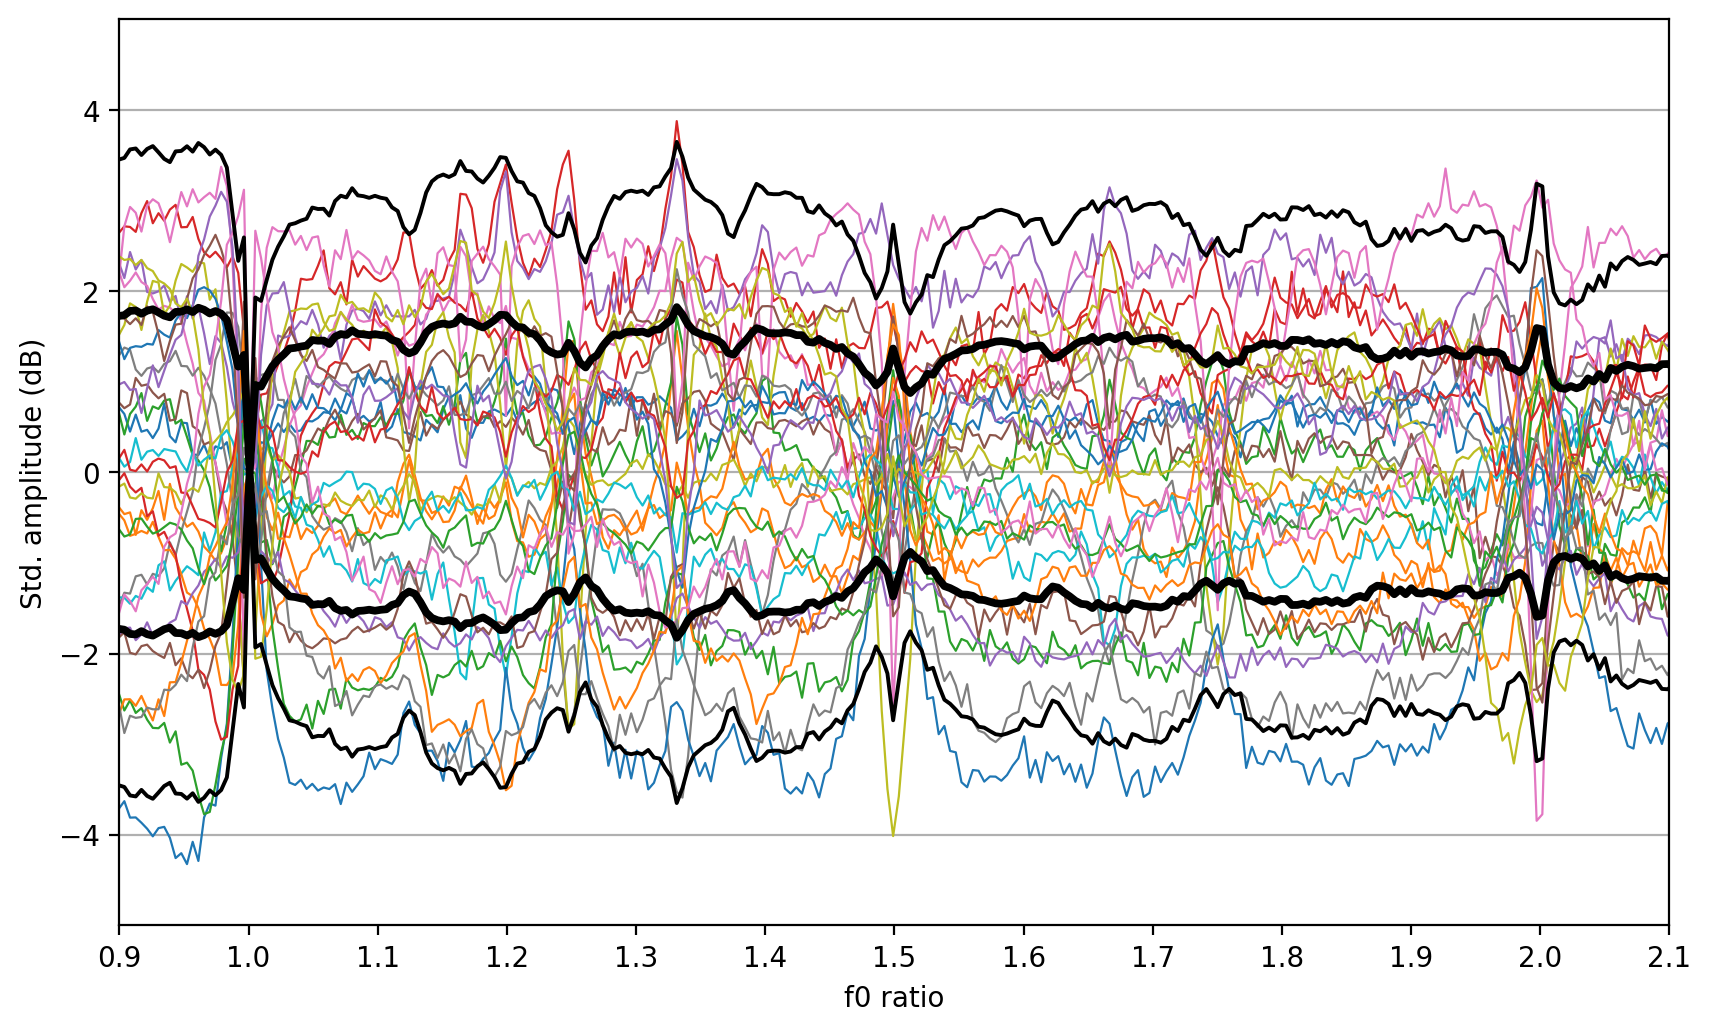

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

for idx, lang in enumerate(langs):
    plt.plot(ratio_idx, spectrum_mean - freq_data_mean_db[:,idx], linewidth=0.8)

plt.plot(ratio_idx, spectrum_std, linestyle="-", c='k',  linewidth=2.8, zorder=99)
plt.plot(ratio_idx, -spectrum_std, linestyle="-", c='k',  linewidth=2.8, zorder=99)
plt.plot(ratio_idx, 2 * spectrum_std, linestyle="-", c='k', linewidth=1.4,  zorder=99)
plt.plot(ratio_idx, -2 * spectrum_std, linestyle="-", c='k', linewidth=1.4, zorder=99)

common = [6/5, 5/4, 4/3, 7/5, 3/2, 8/5, 5/3, 9/5, 2/1]
names = ["m3", "M3", "P4", "tt", "P5", " m6", "M6", "m7", "P8"]
    
ylim_range = 3

for ratio, name in zip(common, names):
    idx = np.argwhere(ratio_idx == find_nearest(ratio_idx, ratio))
    x_val = ratio_idx[idx]
    ymin = np.abs(np.squeeze(spectrum_std[idx])) / ylim_range
    ymax = ymin + 0.08

    ymag = np.squeeze(spectrum_std[idx])

    #plt.axvline(x_val, ymin=ymin-0.05, ymax=ymin-0.1, c='k', zorder=2, linewidth=1.0)
    #plt.text(x_val-0.02, ymag-0.5, name, weight='bold')

plt.xticks(np.arange(0.9, 2.1, 0.1))
plt.xlim([0.9, 2.1])
plt.ylim([-5,5])
plt.ylabel('Std. amplitude (dB)')
plt.xlabel('f0 ratio')
plt.grid(axis='y')
plt.show()

In [ ]:
nlangs = len(langs)
plot_type = "diff" # sum or diff
cmap = mpl.cm.get_cmap('Blues')

fig1 = plt.figure(figsize=(20, 20))
subplot_idx = 1

for langA in langs:
    
    ax = plt.subplot(nlangs, nlangs, subplot_idx)
    ax.set_ylabel(langA)
    
    freq_data_mean_db_fileA = glob.glob(os.path.join(log_dir, langA, "*freq_data_mean_db.txt"))[0]
    ratio_idx_fileA = glob.glob(os.path.join(log_dir, langA, "*ratio_idx.txt"))[0]

    freq_data_mean_dbA = np.loadtxt(freq_data_mean_db_fileA)
    ratio_idx = np.loadtxt(ratio_idx_fileA)
        
    for langB in langs:

        freq_data_mean_db_fileB = glob.glob(os.path.join(log_dir, langB, "*freq_data_mean_db.txt"))[0]
        ratio_idx_fileB = glob.glob(os.path.join(log_dir, langB, "*ratio_idx.txt"))[0]   
        
        freq_data_mean_dbB = np.loadtxt(freq_data_mean_db_fileB)

        ax = plt.subplot(nlangs, nlangs, subplot_idx)

        if plot_type == "diff":
            plot_val = freq_data_mean_dbA-freq_data_mean_dbB
            ax.plot(ratio_idx, plot_val)
            ax.axhline(0, linestyle='--', c='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlim([0.9, 2.1])
            ax.set_ylim([-8,8])
            
        elif plot_type == "sum":
            plot_val = np.sum(np.abs(freq_data_mean_dbA-freq_data_mean_dbB))/3000
            if plot_val > 1.0 or plot_val < -1.0:
                print(plot_val)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlim([0, 1])
            ax.set_ylim([0,1])
            x = [0, 0, 1, 1]
            y = [0, 1, 1, 0]
            ax.fill(x, y, c=cmap(plot_val))

        if subplot_idx <= nlangs:
            ax.set_title(langB)
        
        subplot_idx += 1

plt.show()


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
